# 用来搭建FPN网络的代码

## FPN网络结构解析

ResNet作为特征提取网络，底层的卷积层提取的特征通过上采样和上册特征进行

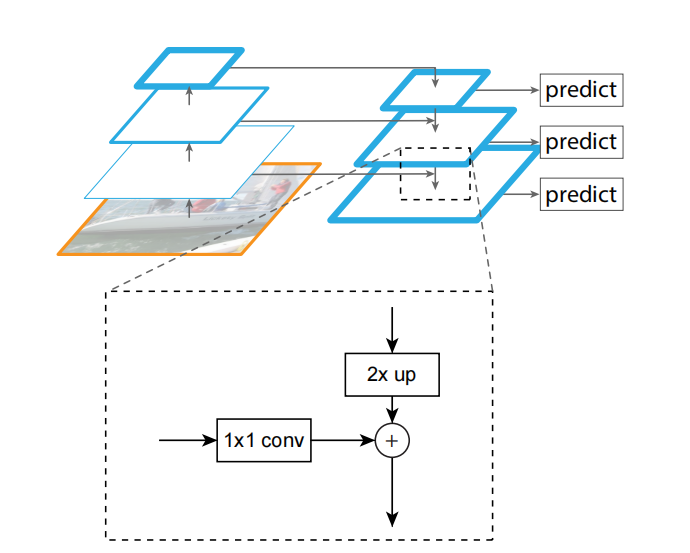

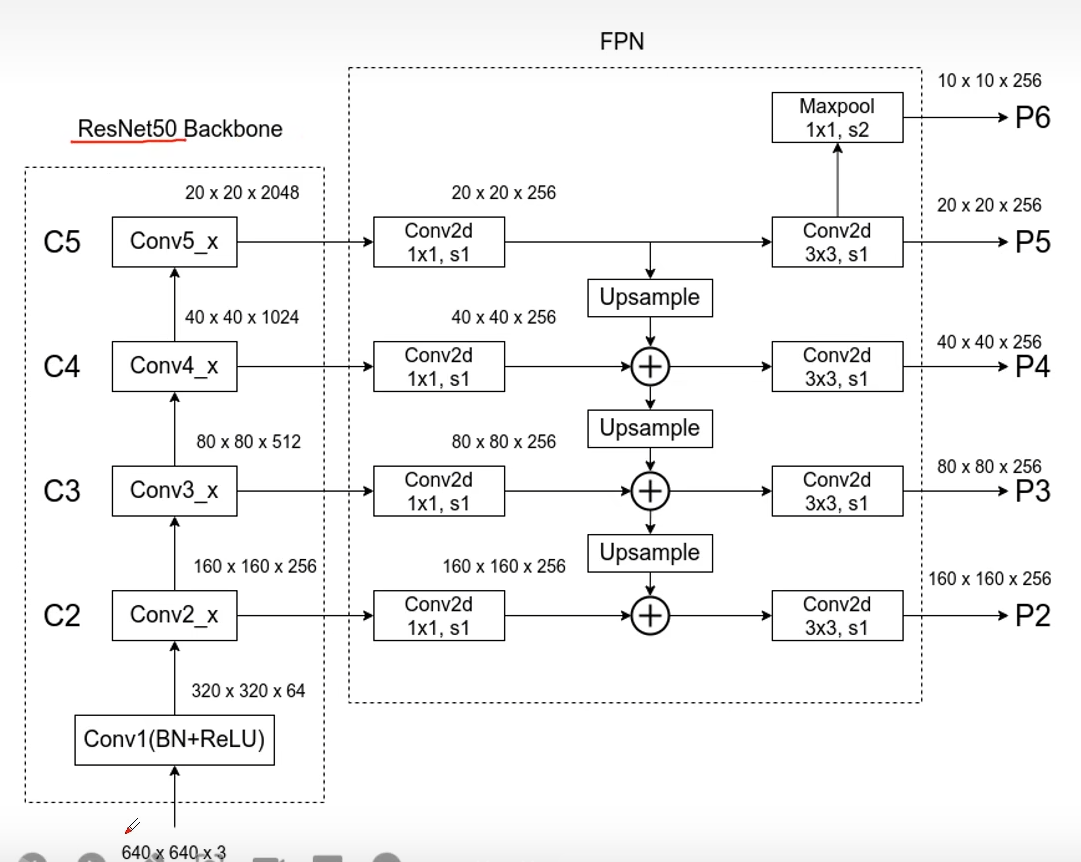

In [ ]:
# # -*- coding: utf-8 -*-

#用于确保在 Python 2 中写的代码在 Python 3 中能够以相似的方式运行。
#这些导入是 "future" 模块的一部分，它们旨在帮助用户将 Python 2 的一些特性和行为转变为 Python 3 风格
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import tensorflow.contrib.slim as slim
from help_utils.help_utils import print_tensors


### 搭建FPN网络的方法 根据传入的共享网络和配置参数搭建


In [ ]:
def build_feature_pyramid(share_net, config, reuse=tf.AUTO_REUSE):
    """
    :param share_net: the dict of network's output at every point.
    :param config: the config of network
    :param reuse:
    :return: the dict of multi-pyramid feature map {P2:,----,P6:}
    """

### 定义backbone网络ResNet各层的卷积大小 
本网络用的是resnet_model 对应文件中libs/networks/nets/means_resnet_v2.py

In [ ]:
    #构建每一层的特征提取层
    feature_maps_dict ={}
    with tf.variable_scope('get_feature_maps', reuse=reuse):
        if config.NET_NAME == 'resnet_v2_50':
            feature_maps_dict = {
                'C2': share_net['resnet_v2_50/block1/unit_2/bottleneck_v2'],  # [256, 256]
                'C3': share_net['resnet_v2_50/block2/unit_3/bottleneck_v2'],  # [128, 128]
                'C4': share_net['resnet_v2_50/block3/unit_5/bottleneck_v2'],  # [64, 64]
                'C5': share_net['resnet_v2_50/block4/unit_3/bottleneck_v2']  # [32, 32]
            }
        elif config.NET_NAME == 'resnet_v2_101':
            feature_maps_dict = {
                'C2': share_net['resnet_v2_101/block1/unit_2/bottleneck_v2'],  # [56, 56]
                'C3': share_net['resnet_v2_101/block2/unit_3/bottleneck_v2'],  # [28, 28]
                'C4': share_net['resnet_v2_101/block3/unit_22/bottleneck_v2'],  # [14, 14]
                'C5': share_net['resnet_v2_101/block4/unit_3/bottleneck_v2']  # [7, 7]
            }
        elif config.NET_NAME == 'resnet_v1_50':
            feature_maps_dict = {
                'C2': share_net['resnet_v1_50/block1/unit_3/bottleneck_v1'],  # [256, 256]
                'C3': share_net['resnet_v1_50/block2/unit_4/bottleneck_v1'],  # [128, 128]
                'C4': share_net['resnet_v1_50/block3/unit_6/bottleneck_v1'],  # [64, 64]
                'C5': share_net['resnet_v1_50/block4/unit_3/bottleneck_v1']  # [32, 32]
            }
        elif config.NET_NAME == 'resnet_v1_101':
            feature_maps_dict = {
                'C2': share_net['resnet_v1_101/block1/unit_2/bottleneck_v1'],  # [56, 56]
                'C3': share_net['resnet_v1_101/block2/unit_3/bottleneck_v1'],  # [28, 28]
                'C4': share_net['resnet_v1_101/block3/unit_22/bottleneck_v1'],  # [14, 14]
                'C5': share_net['resnet_v1_101/block4/unit_3/bottleneck_v1']  # [7, 7]
            }
        elif config.NET_NAME == 'resnet_model':
            feature_maps_dict =  share_net
        else:
            raise Exception('get no feature maps')
    

### 进行上采样 对金字塔进行特征融合构建特征金字塔

In [ ]:
feature_pyramid = {}
    with tf.variable_scope('build_feature_pyramid', reuse=reuse):
        #为后续的slim.conv2d定义一些默认的参数
        with slim.arg_scope([slim.conv2d],
                            activation_fn=None,
                            normalizer_params=None,
                            weights_initializer=tf.glorot_uniform_initializer(),
                            weights_regularizer=slim.l2_regularizer(config.WEIGHT_DECAY)):
            # 构建特征金字塔的第一个层 P5，通过 1x1 卷积将最底层的特征图 C5 转换为 256 个通道
            feature_pyramid['P5'] = slim.conv2d(feature_maps_dict['C5'],
                                                num_outputs=256,
                                                kernel_size=[1, 1],
                                                stride=1,
                                                scope='C5toP5')

            # P6 is down sample of P5
            
            #构建P4 - P2  将上层的特征
            for layer in range(4, 1, -1):
                p, c = feature_pyramid['P' + str(layer + 1)], feature_maps_dict['C' + str(layer)]   #获取上一层的特征图和当前的特征图
                up_sample_shape = tf.shape(c)  #获取当前层的形状
                #将上一层的特征图进行上采样使与c层形状相同
                up_sample = tf.image.resize_images(p,
                                                   [up_sample_shape[1], up_sample_shape[2]])  
                
                #用1x1的卷积操作 调整通道相同
                c = slim.conv2d(c, num_outputs=256, kernel_size=[1, 1], stride=1,
                                scope='C%dtoP%d' %(layer, layer))
                #进行特征融合
                p = up_sample + c
                feature_pyramid['P' + str(layer)] = p
            
            #对每一层的特征用3*3的卷积层进行特征提取 得到最终的P2-P5
            for layer in range(5, 1, -1):
                p = feature_pyramid['P' + str(layer)]
                p = slim.conv2d(p, 256, kernel_size=[3, 3], stride=1,
                                padding='SAME', scope='build_P%d' % layer)
                feature_pyramid['P' + str(layer)] = p
            
            #最后用2*2的卷积核作最大池化操作得到P6
            feature_pyramid['P6'] = slim.max_pool2d(feature_pyramid['P5'],
                                                    kernel_size=[2, 2], stride=2, scope='build_P6')

    return feature_pyramid
